In [1]:
from qiskit.circuit import Parameter
from qiskit import QuantumCircuit
import random
import math

#from qiskit_machine_learning.neural_networks import EstimatorQNN

#from qiskit_algorithms.utils import algorithm_globals

#algorithm_globals.random_seed = 42

In [2]:
QUBITS = 5       #number of qubits
VERBOSE = False  #controls what is printed

In [3]:
def initialise_parameters(qubits):
    #initialise parameter text
    params1 = []
    for i in range(qubits):
        text1 = "weight" + str(2*i)
        text2 = "weight" + str(2*i +1 )
        params1.append(Parameter(text1 ))
        params1.append(Parameter(text2 ))
    #initialise parameters with random weights    
    for i in range(qubits * 2):
        params1[i] = random.random() * 2 * math.pi
        if VERBOSE:
            print(params1[i])
    return params1

In [4]:
def vqc_circuit(qubits, params1):
    #set up a variational quantum circuit
    qc = QuantumCircuit(qubits)
    for i in range(qubits):
        qc.h(i)
        qc.ry(params1[2*i], i)
        qc.rx(params1[2*i+1], i)
    for i in range(qubits-1):
            qc.cx(i,i+1)
    qc.measure_all()
    return qc

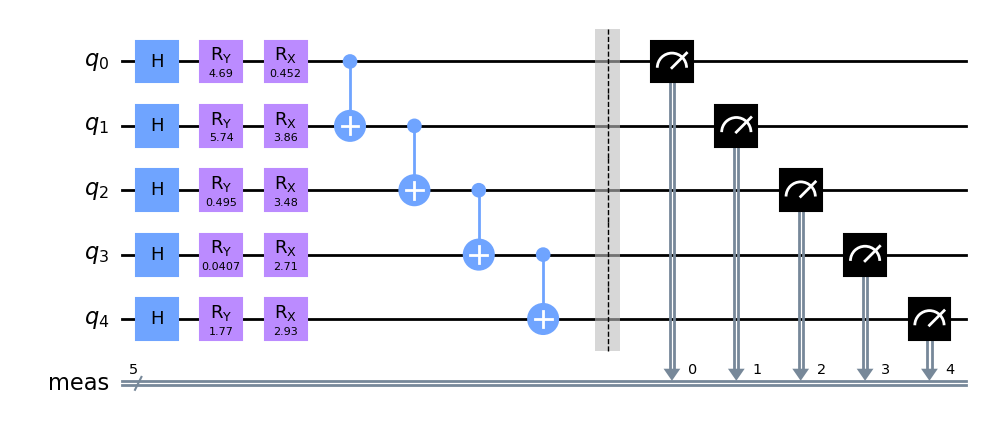

In [5]:
from qiskit_aer.primitives import SamplerV2

sampler = SamplerV2()
SHOTS = 1000

params1 = initialise_parameters(QUBITS)

qc = vqc_circuit(QUBITS, params1)
qc.draw("mpl", style="clifford")

In [6]:
job = sampler.run([qc], shots = SHOTS)
result_ideal = job.result()
counts_ideal = result_ideal[0].data.meas.get_counts()
print(counts_ideal)

{'11010': 91, '00100': 36, '00001': 11, '11110': 252, '00000': 95, '00110': 236, '00010': 95, '11000': 99, '00111': 7, '11101': 4, '01010': 1, '11111': 3, '11100': 32, '01000': 3, '00101': 10, '01100': 2, '11001': 11, '10110': 5, '01110': 3, '00011': 1, '10000': 1, '11011': 2}
